In [1]:
import numpy as np
import scipy
import pandas as pd
from matplotlib import pyplot as plt
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')
import seaborn
import joblib
from sklearn.preprocessing import Normalizer, MaxAbsScaler
from IPython.utils import io
from multiprocessing import Pool

%matplotlib inline
%load_ext autoreload
%autoreload 2

from data_mining import *
from stacking.stacking import Stacking

In [2]:
residues_normalizer = Normalizer()
hbonds_normalizer = MaxAbsScaler()
solvation_normalizer = MaxAbsScaler()
backboneatom_normalizer = Normalizer()

CASP = [
    ('*residues-d4-b10-a12-c5-n0--skip_errors.mat',
     '8269eab4b9ebaa69aa1467308c48ed4f',
     lambda X: residues_normalizer.fit_transform(X),
     lambda X: residues_normalizer.transform(X)),
    ('*hbonds-b6-a6-c6-n2--skip_errors.mat',
     '8269eab4b9ebaa69aa1467308c48ed4f',
     lambda X: hbonds_normalizer.fit_transform(X),
     lambda X: hbonds_normalizer.transform(X)),
    ('*solvation-b3-a2-c15--skip_errors.mat',
     '8269eab4b9ebaa69aa1467308c48ed4f',
     lambda X: solvation_normalizer.fit_transform(X),
     lambda X: solvation_normalizer.transform(X)),
    ('*backboneatom-b25-c7-n0--residue_type_dependent--skip_errors.mat',
     'd3efaf4824785305b93d775d0e3b0a46',
     lambda X: backboneatom_normalizer.fit_transform(X),
     lambda X: backboneatom_normalizer.transform(X)),
]

NMA = [
    ('*residues-d4-b10-a12-c5-n0--skip_errors.mat',
     'c4f25d107683b57acbc6306d9f5108f2',
     lambda X: residues_normalizer.fit_transform(X),
     lambda X: residues_normalizer.transform(X)),
    ('*hbonds-b6-a6-c6-n2--skip_errors.mat',
     'c4f25d107683b57acbc6306d9f5108f2',
     lambda X: hbonds_normalizer.fit_transform(X),
     lambda X: hbonds_normalizer.transform(X)),
    ('*solvation-b3-a2-c15--skip_errors.mat',
     'c4f25d107683b57acbc6306d9f5108f2',
     lambda X: solvation_normalizer.fit_transform(X),
     lambda X: solvation_normalizer.transform(X)),
    ('*backboneatom-b25-c7-n0--residue_type_dependent--skip_errors.mat',
     'c4f25d107683b57acbc6306d9f5108f2',
     lambda X: backboneatom_normalizer.fit_transform(X),
     lambda X: backboneatom_normalizer.transform(X)),
]

In [3]:
%%time

X, scores = combine_datasets(
    get_dataset(
        [(pattern, checksum, fit_transform)
             for (pattern, checksum, fit_transform, transform) in CASP],
        '^.*CASP([5-9]|10)/T..../.*$'
    ),
#     get_dataset(
#         [(pattern, checksum, transform)
#              for (pattern, checksum, fit_transform, transform) in NMA],
#         '^.*CASP([5-9]|10)/T..../.*$'
#     )
)

Shape of the first dataset:  (160586, 4371840)
Shape of the second dataset: (160586, 216)
Shape of the final dataset:  (160586, 4372056)
Shape of the first dataset:  (160586, 4372056)
Shape of the second dataset: (160586, 138)
Shape of the final dataset:  (160586, 4372194)
Shape of the first dataset:  (160586, 4372194)
Shape of the second dataset: (160579, 239775)
Shape of the final dataset:  (160579, 4611969)
CPU times: user 9min 45s, sys: 2min 35s, total: 12min 21s
Wall time: 12min 22s


In [6]:
targets = list(set([x.split('/')[6] for x in scores.index if x.split('/')[5] != 'CASP11']))

idx_list = []

np.random.seed(1)
for p in np.linspace(0.01, 0.1, 6, endpoint=False):
    train_targets = np.random.choice(targets, int(len(targets) * p), replace=False)
    idx_list.append(np.array([x.split('/')[6] in train_targets for x in scores.index], dtype=bool))

np.random.seed(1)
for p in np.linspace(0.1, 1, 15):
    train_targets = np.random.choice(targets, int(len(targets) * p), replace=False)
    idx_list.append(np.array([x.split('/')[6] in train_targets for x in scores.index], dtype=bool))

# Load assessors

In [16]:
def test_assessor(args):
    model, idx = args
    try:
        assessor = joblib.load(model)
        normalizers = assessor.steps[0][1].normalizers
        pipeline = assessor.steps[1][1]

        X_test, scores_test = X[idx], scores[idx]

        natives_included = scoring_results(X_test, scores_test,
                                           lambda X: pipeline.predict(X),
                                           num_plots=0)[0]['GDT-TS-score']

        natives_excluded = scoring_results(X_test[~get_natives(scores_test).values],
                                           scores_test[~get_natives(scores_test).values],
                                           lambda X: pipeline.predict(X),
                                           num_plots=0)[0]['GDT-TS-score']

        return model, natives_included, natives_excluded
    except Exception as e:
        return model, pd.Series(), pd.Series()

def to_df(model, records):
    df = pd.concat(records, axis=1).T
    df.insert(0, 'Model', model)
    return df[~df.isnull().any(1)]


pool = Pool(5)
results = pool.map(test_assessor, [(model, idx) for model in glob.glob('ridge_pipeline_CASP_*__{}_*.pkl'.format(sum(idx))) for idx in idx_list])
model, records_natives_included, records_natives_excluded = zip(*results)
results_natives_included, results_natives_excluded = (to_df(model, records_natives_included),
                                                      to_df(model, records_natives_excluded))

In [29]:
list(map(sum, idx_list))

[1416,
 3812,
 6423,
 8633,
 10887,
 13897,
 15489,
 26270,
 36881,
 47367,
 56994,
 67751,
 77835,
 87707,
 98843,
 108399,
 118758,
 128997,
 140402,
 150219,
 160579]

In [25]:
[(model, idx) for idx in idx_list for model in glob.glob('ridge_pipeline_CASP_*__{}_*.pkl'.format(sum(idx)))]

[('ridge_pipeline_CASP_564__160579_4611969.pkl',
  array([ True,  True,  True, ...,  True,  True,  True], dtype=bool))]

#### excluding native

In [17]:
results_natives_excluded

Model  \
GDT-TS-score  ridge_pipeline_CASP_564__160579_4611969.pkl   
GDT-TS-score  ridge_pipeline_CASP_564__160579_4611969.pkl   
GDT-TS-score  ridge_pipeline_CASP_564__160579_4611969.pkl   
GDT-TS-score  ridge_pipeline_CASP_564__160579_4611969.pkl   
GDT-TS-score  ridge_pipeline_CASP_564__160579_4611969.pkl   
GDT-TS-score  ridge_pipeline_CASP_564__160579_4611969.pkl   
GDT-TS-score  ridge_pipeline_CASP_564__160579_4611969.pkl   
GDT-TS-score  ridge_pipeline_CASP_564__160579_4611969.pkl   
GDT-TS-score  ridge_pipeline_CASP_564__160579_4611969.pkl   
GDT-TS-score  ridge_pipeline_CASP_564__160579_4611969.pkl   
GDT-TS-score  ridge_pipeline_CASP_564__160579_4611969.pkl   
GDT-TS-score  ridge_pipeline_CASP_564__160579_4611969.pkl   
GDT-TS-score  ridge_pipeline_CASP_564__160579_4611969.pkl   
GDT-TS-score  ridge_pipeline_CASP_564__160579_4611969.pkl   
GDT-TS-score  ridge_pipeline_CASP_564__160579_4611969.pkl   
GDT-TS-score  ridge_pipeline_CASP_564__160579_4611969.pkl   
GDT-TS-score  ridge_pipeline_CASP_564__160579_4611969.pkl   
GDT-TS-score  ridge_pipeline_CASP_564__160579_4611969.pkl   
GDT-TS-score  ridge_pipeline_CASP_564__160579_4611969.pkl   
GDT-TS-score  ridge_pipeline_CASP_564__160579_4611969.pkl   
GDT-TS-score  ridge_pipeline_CASP_564__160579_4611969.pkl   

             Mean rank of the native      Top 1     Top 5  \
GDT-TS-score                      66          0         0   
GDT-TS-score                 34.2143  0.0714286  0.214286   
GDT-TS-score                 32.8636  0.0454545  0.272727   
GDT-TS-score                 31.6774  0.0322581  0.258065   
GDT-TS-score                 24.1026   0.025641  0.153846   
GDT-TS-score                  45.234   0.106383  0.234043   
GDT-TS-score                 45.1964  0.0535714  0.142857   
GDT-TS-score                 36.2174   0.076087  0.271739   
GDT-TS-score                 33.1953  0.0703125  0.242188   
GDT-TS-score                 41.2121  0.0545455       0.2   
GDT-TS-score                 36.0299   0.039801  0.208955   
GDT-TS-score                 37.2405  0.0548523  0.274262   
GDT-TS-score                 39.1868  0.0732601  0.234432   
GDT-TS-score                 36.6871  0.0645161  0.248387   
GDT-TS-score                 39.0838  0.0520231  0.216763   
GDT-TS-score                 38.2435   0.065445  0.246073   
GDT-TS-score                 37.6435  0.0550239  0.246411   
GDT-TS-score                 37.2352  0.0615385  0.237363   
GDT-TS-score                 36.8452  0.0631365  0.230143   
GDT-TS-score                  37.019  0.0588235  0.233397   
GDT-TS-score                 37.4326  0.0638298  0.237589   

             Mean score for top 1 Mean loss score Mean Pearson Mean Spearman  \
GDT-TS-score              0.42142         0.04716    -0.783717     -0.729631   
GDT-TS-score             0.576036       0.0476286    -0.871348     -0.798068   
GDT-TS-score             0.602291       0.0324636    -0.861785     -0.776439   
GDT-TS-score             0.603452       0.0384548    -0.874452     -0.809317   
GDT-TS-score             0.564649       0.0438282    -0.845589     -0.796452   
GDT-TS-score             0.613515       0.0459489     -0.87533     -0.813679   
GDT-TS-score             0.607716       0.0420304    -0.884761     -0.808382   
GDT-TS-score             0.646526       0.0335054    -0.888007     -0.810963   
GDT-TS-score             0.622514       0.0442984    -0.872468     -0.800767   
GDT-TS-score             0.601696       0.0414612    -0.869135     -0.798342   
GDT-TS-score             0.607585       0.0460965      -0.8635     -0.795449   
GDT-TS-score             0.590918       0.0456667    -0.860073      -0.79826   
GDT-TS-score             0.594774        0.043711     -0.86704     -0.804451   
GDT-TS-score             0.592712       0.0471658    -0.857244     -0.792542   
GDT-TS-score             0.597475       0.0432855     -0.86493     -0.799011   
GDT-TS-score               0.5936       0.0447346    -0.861621     -0.800221   
GDT-TS

## Plot

In [22]:
csv_name = 'learning_curve_CASP.csv'
results_natives_excluded.to_csv(csv_name)

In [18]:
x = results_natives_excluded[results_natives_excluded.Model.apply(lambda x: x.startswith('ridge_pipeline_CASP_'))]

In [19]:
df = -x[['Mean Pearson', 'Mean Spearman', 'Mean Kendall tau', 'Mean loss score']]
df.index = pd.Series(x.Model.apply(lambda x: int(x.split('__')[-2].split('_')[-1])), name='Domains number')
df.sort_index(inplace=True)

/home/m.karasikov/anaconda3/lib/python3.5/site-packages/matplotlib/axes/_base.py:2917: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=564.0, right=564.0
  'left=%s, right=%s') % (left, right))


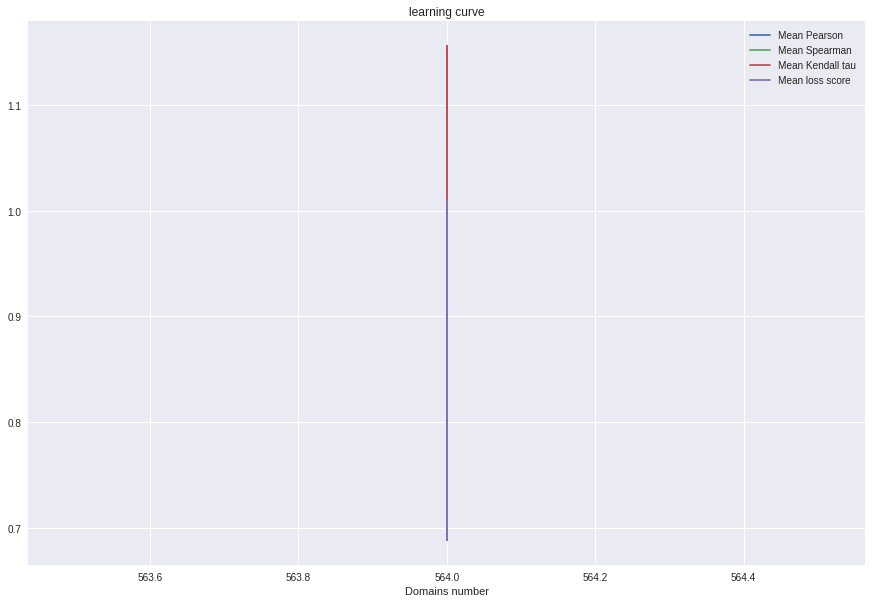

In [20]:
(df / df.iloc[0]).plot(figsize=(15, 10))
plt.title('learning curve')
plt.show()